# Importing Libraries

In [2]:
from matplotlib.ticker import FuncFormatter
from pandas.io.json import json_normalize
from urllib.request import urlopen,Request
import time
from IPython.display import Image
import json
import locale
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import sqlalchemy
import sqlite3
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import datetime
import ast
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly
plotly.tools.set_credentials_file(username='KonradBorowiec', api_key='xTMcQX56nKbYbDAcPJp6')
#https://plot.ly/python/getting-started/

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)


# Collecting and cleaning data sets

# Collecting

## Movies

### Fields descriptions

- budget: budget of the movie in dollars
- id: ID of the movie
- imdb_id: IMDB ID of the movie
- original_language: language in which the movie was originally shot in
- original_title: original title of the movie
- overview: a brief description of the movie
- popularity: popularity score
- poster_path: URL of the poster image
- release_date: release date of the movie
- revenue: total revenue of the movie in dollars
- runtime: runtime of the movie in minutes
- status: status of the movie
- title: official title of the movie
- vote_average: average rating of the movie
- vote_count: number of votes by users

In [12]:
def movies(directory, headers, api_key, stop, start, writing_mode):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/' + str(start) + '?api_key=' + api_key)
        data = response.json()
        filtered_data = {k : v for k, v in filter(lambda t: t[0] in headers, data.items())}
        df = pd.DataFrame(filtered_data, index = [0])
                 
        with open('movies.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        print(start)
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'movies.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2], 3: header_to_pass[3], 4: header_to_pass[4], 5: header_to_pass[5], 6: header_to_pass[6], 7: header_to_pass[7], 8: header_to_pass[8], 9: header_to_pass[9], 10: header_to_pass[10], 11: header_to_pass[11], 12: header_to_pass[12], 13: header_to_pass[13], 14: header_to_pass[14], 15: header_to_pass[15]}, inplace=True)
    df.to_csv(directory + '/backup/movies.csv', index = False)

    with open(directory + '/backup/movies.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]] , i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]], i[header_to_pass[9]], i[header_to_pass[10]], i[header_to_pass[11]], i[header_to_pass[12]], i[header_to_pass[13]], i[header_to_pass[14]], i[header_to_pass[15]] ) for i in dr]

        
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS movies
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS movies(idx STR, budget INT, id STR, imdb_id STR, original_language STR, original_title STR, overview STR,
                  popularity FLOAT, poster_path STR, release_date DATE, revenue FLOAT, runtime INT, status STR, title STR, vote_average FLOAT, vote_count INT)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO movies VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    con.close()


directory = '/home/konrad/movies/'
headers = ["budget", "id","imdb_id", "original_language", "original_title", "overview", "popularity", "poster_path", "release_date","revenue","runtime","status","title","vote_average","vote_count"]
api_key = 'e4f5b3b79e2ab374455c1c1e1d0ca014'
stop = 72501
start = 72500
writing_mode = 'a'

movies(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
72500


## Genres


### Fields descriptions

- id: ID of the genre
- name: genre name
- imdb_id: the IMDB ID of the movie


In [13]:
def genres(directory, headers, api_key, stop, start, writing_mode):
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/' + str(start) +'?api_key=' +  api_key)
        data = response.json()
        
        if 'The resource you requested could not be found.' in data.values():
            start += 1
            
        else:            
            data_normalized = json_normalize(data, "genres", ["imdb_id"])
            df = pd.DataFrame(data_normalized, index = [0])
            
            with open('genres.csv', str(writing_mode)) as f:
                df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
            print(start)
            
        start += 1

    header_to_pass = ["idx"] + headers

    df = pd.read_csv(directory + 'genres.csv', header=None, names=header_to_pass, error_bad_lines=False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2], 3: header_to_pass[3]}, inplace=True)
    df.to_csv(directory + '/backup/genres.csv', index=False)

    with open(directory + '/backup/genres.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter=',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]]) for i in dr]

    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS genres
    ''')
    con.commit()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS genres(idx STR, id STR, name STR, imdb_id STR)
    ''')
    con.commit()

    cursor.executemany("INSERT INTO genres VALUES (?,?,?,?);", to_db)
    con.commit()
    con.close()
    

    
directory = '/home/konrad/movies/'
headers = ["id", "name", "imdb_id"]
api_key = '69d2d11ea34cd0ff95c454c73786a6a7'
stop = 72501
start = 72500
writing_mode = 'a'

genres(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
72500


## Production Countries


### Fields descriptions

- iso_3166_1: the ID of country
- name: genre name
- imdb_id: the IMDB ID of the movie


In [24]:
def productionCountries(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
        
    while start < stop:
        response = requests.get('https://api.themoviedb.org/3/movie/'+ str(start) +'?api_key='+  api_key)
        data = response.json()
        
        if 'The resource you requested could not be found.' in data.values():
            start += 1
            
        else:
            data_normalized = json_normalize(data,"production_countries",["imdb_id"])
            df = pd.DataFrame(data_normalized, index = [0])

            with open('productioncountries.csv', str(writing_mode)) as f:
                df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
            print(start)
        
        start += 1

    df = pd.read_csv(directory + '/productioncountries.csv', header = None, names = headers, error_bad_lines = False)
    df.rename(columns={0: headers[0], 1: headers[1], 2: headers[2]}, inplace = True)
    df.to_csv(directory + 'backup/productioncountries.csv', index = False)

    with open(directory + '/backup/productioncountries.csv', 'r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[headers[0]], i[headers[1]], i[headers[2]]) for i in dr]

    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    cursor.execute('''
    DROP TABLE IF EXISTS productioncountries
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS productioncountries(iso_3166_1 STR, name STR, imdb_id STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO productioncountries VALUES (?,?,?);", to_db)
    con.commit()
    con.close()

directory = '/home/konrad/movies/'
headers = ["iso_3166_1", "name", "imdb_id"]
api_key = 'ab9bd0e209dd5c8bf42b028a63bc4e29'
stop = 199710
start = 199709
writing_mode = 'a'

productionCountries(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
199704
199705
199708
199709


##  Keywords


### Fields descriptions

- keywords: tags used to describe a movie
- id: ID of the movie

In [94]:
def keywords(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
          
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/keywords?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data, "keywords", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)

        with open(directory + 'keywords.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        print(start) 
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'keywords.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns={0: header_to_pass[0], 1: header_to_pass[1], 2: header_to_pass[2]}, inplace = True)
    df.to_csv(directory + '/backup/keywords.csv', index = False)

    with open(directory + '/backup/keywords.csv','r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]]) for i in dr]
        
    
    cursor.execute('''
        DROP TABLE IF EXISTS keywords
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS keywords(idx STR, keywords STR, id STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO keywords VALUES (?,?,?);", to_db)
    con.commit()
    con.close()
    

directory = '/home/konrad/movies/'
headers = ["keywords", "id"]
api_key = 'e4f5b3b79e2ab374455c1c1e1d0ca014'
stop = 31001
start = 31000
writing_mode = 'a'

keywords(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
31000


## Cast


### Fields descriptions

- cast_id: 
- character:
- credit_id:
- imgenderdb_id:
- id:
- name:
- Movie.order:
- profile_path: 
- Movie.id:

In [15]:
def cast(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/casts?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data, "cast", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)

        with open(directory + 'cast.csv', str(writing_mode)) as f:
            df.to_csv(f, header = False, sep = ',', encoding = 'utf-8')
        
        print(start)    
        start += 1
        
    header_to_pass = ["idx"] + headers

    df = pd.read_csv(directory + 'cast.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns = {0: header_to_pass[0], 1:  header_to_pass[1], 2:  header_to_pass[2], 3:  header_to_pass[3], 4:  header_to_pass[4], 5:  header_to_pass[5], 6:  header_to_pass[6], 7:  header_to_pass[7], 8:  header_to_pass[8], 9:  header_to_pass[9]}, inplace=True)
    df.to_csv(directory + '/backup/cast.csv', index = False)

    with open(directory + '/backup/cast.csv','r') as table:
        dr = csv.DictReader(table, delimiter = ',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]], i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]], i[header_to_pass[9]]) for i in dr]


    cursor.execute('''
        DROP TABLE IF EXISTS cast
    ''')
    con.commit()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS cast(idx STR, cast_id STR, character STR, credit_id STR, gender STR, id STR, name STR, "Movie.order" STR, profile_path STR, "Movie.id" STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO cast VALUES (?,?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    con.close()
    
        

directory = '/home/konrad/movies/'
headers = ["cast_id", "character", "credit_id", "imgenderdb_id", "id", "name", "Movie.order", "profile_path", "Movie.id"]
api_key = 'ab9bd0e209dd5c8bf42b028a63bc4e29'
stop = 25213
start = 25212
writing_mode = 'a'

cast(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies
25212


## Crew

### Fields descriptions

- credit_id:
- department:
- gender:
- id:
- job: 
- name:
- profile_path: 
- Movie.id:

In [11]:
def crew(directory, headers, api_key, stop, start, writing_mode):

    if not os.path.exists(directory):
        os.makedirs(directory)
        os.chdir(directory)
    else:
        os.chdir(directory)
    print(os.getcwd())
    
    con = sqlite3.connect(directory + 'movies.sqlite')
    cursor = con.cursor()
    
    df = pd.read_sql_query("SELECT imdb_id FROM (SELECT DISTINCT imdb_id FROM movies) WHERE imdb_id <> ''", con)
    l = df['imdb_id'].tolist()
    editedList = l[start:stop]

    for i in editedList:
        response = requests.get("https://api.themoviedb.org/3/movie/" + i + "/casts?api_key=" + api_key)
        data = response.json()
        data_normalized = json_normalize(data,"crew", ["id"], meta_prefix = "Movie.")
        df = pd.DataFrame(data_normalized)
                 
        with open('crew.csv', str(writing_mode)) as f:
            df.to_csv(f, header=False, sep=',', encoding='utf-8')
        
        print(start)    
        start += 1
        
    header_to_pass = ["idx"] + headers
    
    df = pd.read_csv(directory + 'crew.csv', header = None, names = header_to_pass, error_bad_lines = False)
    df.rename(columns = {0: header_to_pass[0], 1: header_to_pass[1] ,2: header_to_pass[2], 3: header_to_pass[3], 4: header_to_pass[4], 5: header_to_pass[5], 6: header_to_pass[6], 7: header_to_pass[7], 8: header_to_pass[8]}, inplace = True)
    df.to_csv(directory + '/backup/crew.csv', index = False)

    with open(directory + '/backup/crew.csv','r') as table:
        dr = csv.DictReader(table, delimiter=',')
        to_db = [(i[header_to_pass[0]], i[header_to_pass[1]], i[header_to_pass[2]], i[header_to_pass[3]], i[header_to_pass[4]], i[header_to_pass[5]], i[header_to_pass[6]], i[header_to_pass[7]], i[header_to_pass[8]]) for i in dr]

    
    cursor.execute('''
    DROP TABLE IF EXISTS crew
    ''')
    con.commit()
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS crew(idx STR, credit_id STR, department STR, gender STR, id STR, job STR, name STR, profile_path STR, "Movie.id" STR)
    ''')
    con.commit()
    
    cursor.executemany("INSERT INTO crew VALUES (?,?,?,?,?,?,?,?,?);", to_db)
    con.commit()
    
    

directory = '/home/konrad/movies/'
headers = ["credit_id", "department", "gender", "id", "job", "name", "profile_path", "Movie.id"]
api_key = '69d2d11ea34cd0ff95c454c73786a6a7'
stop = 72500
start = 25182
writing_mode = 'a'
        
crew(directory, headers, api_key, stop, start, writing_mode)

/home/konrad/movies


# Cleaning

> Quering tables from movies.sqlite data base gives an information about empty rows and duplicate entries which have been pulled out during desining and testing of ETL process.

## Movies Dataset

In [7]:
con = sqlite3.connect('/home/konrad/movies/movies.sqlite')
c = con.cursor()

### Characteristics of Movie table before cleaning

> Tha shape of Movies table:

In [5]:
pd.read_sql_query("SELECT * FROM movies;", con).shape

(1315887, 16)

> Attributes of fields:

In [11]:
pd.read_sql_query("SELECT * FROM movies;", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315886 entries, 0 to 1315885
Data columns (total 16 columns):
idx                  1315886 non-null object
budget               1315886 non-null object
id                   1315886 non-null object
imdb_id              1315886 non-null object
original_language    1315886 non-null object
original_title       1315886 non-null object
overview             1315886 non-null object
popularity           1315886 non-null object
poster_path          1315886 non-null object
release_date         1315886 non-null object
revenue              1315886 non-null object
runtime              1315886 non-null object
status               1315886 non-null object
title                1315886 non-null object
vote_average         1315886 non-null object
vote_count           1315886 non-null object
dtypes: object(16)
memory usage: 160.6+ MB


> Summary statistics

In [16]:
pd.read_sql_query("SELECT * FROM movies;", con).describe()

,idx,budget,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,title,vote_average,vote_count
count,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887,1315887
unique,41,1133,52479,47753,87,50655,48219,8334,50848,16456,5688,347,7,49714,93,1909
top,0,,,,,,,,,,,,,,,
freq,136235,1199675,1199675,1204401,1199675,1199675,1202256,1263413,1264898,1264521,1263417,1268550,1263417,1263417,1263417,1263417


> Count of doubled entries due to quality of streamed data for ETL process:

In [66]:
pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM movies GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt0436852,tt0416746,tt1585561,tt2061710,1942-07-20,2005-05-10,2009-08-20,2009-10-23,tt0000001
imdb_id_count,1204401,30093,20250,8729,4666,1,1,1,1,1


### Characteristics of Movie table after cleaning

> Tha shape of Movies table:

In [50]:
pd.read_sql_query("SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')", con).shape

(47747, 16)

> Attributes of fields:

In [49]:
pd.read_sql_query("SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47747 entries, 0 to 47746
Data columns (total 16 columns):
idx                  47747 non-null int64
budget               47747 non-null int64
id                   47747 non-null int64
imdb_id              47747 non-null object
original_language    47747 non-null object
original_title       47747 non-null object
overview             47747 non-null object
popularity           47747 non-null object
poster_path          47747 non-null object
release_date         47747 non-null object
revenue              47747 non-null object
runtime              47747 non-null object
status               47747 non-null object
title                47747 non-null object
vote_average         47747 non-null object
vote_count           47747 non-null object
dtypes: int64(3), object(13)
memory usage: 5.8+ MB


> Transposing Movies table:

In [64]:
pd.read_sql_query("SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
budget,0,0,4000000,21,42000,0,11000000,94000000,55000000,15000000
id,2,3,5,6,8,9,11,12,13,14
imdb_id,tt0094675,tt0092149,tt0113101,tt0107286,tt0825671,tt0425473,tt0076759,tt0266543,tt0109830,tt0169547
original_language,fi,fi,en,en,en,de,en,en,en,en
original_title,Ariel,Varjoja paratiisissa,Four Rooms,Judgment Night,Life in Loops (A Megacities RMX),Sonntag im August,Star Wars,Finding Nemo,Forrest Gump,American Beauty
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."
popularity,5.603,3.789,9.823,6.935,0.6,0.952,33.015,25.552,23.149,18.132
poster_path,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg,/lfaiYUVL7vPE57xgTscJN3kN5P1.jpg,/eQs5hh9rxrk1m4xHsIz1w11Ngqb.jpg,/lNXmgUrP6h1nD53gkFh4WDzT6RZ.jpg,/8YyIjOAxwzD3fZMdmJrfiApod4l.jpg,,/btTdmkgIvOi0FFip1sPuZI2oQG6.jpg,/syPWyeeqzTQIxjIUaIFI7d0TyEY.jpg,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,/3UBQGKS8c1dxRnDiu5kUK6ej3pP.jpg
release_date,1988-10-21,1986-10-17,1995-12-09,1993-10-15,2006-01-01,2004-09-02,1977-05-25,2003-05-30,1994-07-06,1999-09-15


In [34]:
pd.read_sql_query("SELECT DISTINCT * FROM movies WHERE imdb_id <> '' AND imdb_id NOT IN ('1942-07-20','2005-05-10','2009-08-20','2009-10-23')", con).tail(10).transpose()

,47737,47738,47739,47740,47741,47742,47743,47744,47745,47746
idx,0,0,0,0,0,0,0,0,0,0
budget,0,0,0,0,0,0,0,0,0,0
id,72489,72490,72491,72492,72494,72495,72496,72497,72498,72499
imdb_id,tt1161444,tt0201517,tt0078357,tt1822299,tt0075140,tt0022694,tt0012187,tt0010879,tt1978472,tt0390936
original_language,zh,ja,cs,en,de,de,en,en,zh,en
original_title,漂浪青春,カリスマ,Tajemství Ocelového mesta,Roy Chubby Brown: Too Fat To Be Gay,Der Richter und sein Henker,Das blaue Licht,Forbidden Fruit,When the Clouds Roll By,Er Duo Da You Fu,BlackJack: In the Money
overview,Three poetic tales of seeking the true identit...,A seasoned detective is called in to rescue a ...,The film is a metaphor for the Cold War. It de...,"Britain’s most outrageous comedian, bar none! ...",Hans Baerlach is a Swiss police detective who ...,"A young woman, Junta (Riefenstahl), lives apar...",Mary Maddock becomes a seamstress after her hu...,Daniel Boone Brown is a pleasure-seeking playb...,A middle-aged man sets out to find a new caree...,Jack uncovers a disturbing new plot in the uns...
popularity,0.614,0.6,1.266,0.6,0.947,0.6,1.4,0.762,0.6,0.6
poster_path,/2lg1RkYHnLE2IqeW6B5IxkYvw1J.jpg,/pUPdHFmGMHfNrPIDcde2DC6T7IZ.jpg,/xDaRigKgkFW0wDBZcP7Fyz80oQi.jpg,/yZhwSsMseS5zee9mUze7EBwgVM7.jpg,/4ClzOSeNcwcd8huBTyItHwGeeGg.jpg,/a6wuo9U0mzsw2Nma9nVg1NFlus3.jpg,/ofdYsFWBT3miJ5cMbAWhoWWWTnv.jpg,/u1fzrng8MHzGYTHksrZepW5Uw83.jpg,/IcylA7i4txYluuzjep0kSXSdf7.jpg,/gTB6GdCd91dvIix4w0OBzzfE2gC.jpg
release_date,2008-02-10,1999-11-10,1979-05-01,2009-11-09,1975-08-31,1932-03-24,1921-01-03,1919-12-28,2008-01-04,2005-09-11


## Genres Dataset

### Characteristics of Genres table before cleaning:

> Tha shape of Genres table:

In [14]:
pd.read_sql_query("SELECT * FROM genres;", con).shape

(45382, 4)

> Attributes of fields:

In [74]:
pd.read_sql_query("SELECT * FROM genres;", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45381 entries, 0 to 45380
Data columns (total 4 columns):
idx        45381 non-null int64
id         45381 non-null object
name       45381 non-null object
imdb_id    45381 non-null object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


Count of doubled entries due to quality of streamed data for ETL process:

In [75]:
pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM genres GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
imdb_id,,tt0022905,tt0023074,tt0023470,tt0024772,tt0024963,tt0026914,tt0027958,tt0033382,tt0034736
imdb_id_count,6901,2,2,2,2,2,2,2,2,2


### Basic characteristics of Genres table after cleaning

> Tha shape of Movies table:

In [69]:
pd.read_sql_query("SELECT DISTINCT * FROM genres WHERE imdb_id <> '';", con).shape

(38428, 4)

> Attributes of fields:

In [192]:
pd.read_sql_query("SELECT DISTINCT * FROM genres WHERE imdb_id <> '';", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38124 entries, 0 to 38123
Data columns (total 4 columns):
idx        38124 non-null int64
id         38124 non-null int64
name       38124 non-null object
imdb_id    38124 non-null object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


> Transposing Movies table:

In [193]:
pd.read_sql_query("SELECT DISTINCT * FROM genres WHERE imdb_id <> '';", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
id,18,18,28,18,16,35,18,9648,18,27
name,Drama,Drama,Action,Drama,Animation,Comedy,Drama,Mystery,Drama,Horror
imdb_id,tt0094675,tt0092149,tt0107286,tt0425473,tt0266543,tt0109830,tt0169547,tt0033467,tt0168629,tt0411267


In [68]:
pd.read_sql_query("SELECT DISTINCT * FROM genres WHERE imdb_id <> '';", con).tail(10).transpose()

,38418,38419,38420,38421,38422,38423,38424,38425,38426,38427
idx,0,0,0,0,0,0,0,0,0,0
id,18,35,18,18,18,35,9648,18,18,10749
name,Drama,Comedy,Drama,Drama,Drama,Comedy,Mystery,Drama,Drama,Romance
imdb_id,tt0120392,tt1754446,tt1161444,tt0201517,tt0078357,tt1822299,tt0075140,tt0022694,tt0012187,tt0010879


## Production Countries Dataset

### Characteristics of Production Countries table before cleaning:

> Tha shape of Production Countries table:

In [76]:
pd.read_sql_query("SELECT * FROM productioncountries;", con).shape

(93440, 3)

> Attributes of fields:

In [77]:
pd.read_sql_query("SELECT * FROM productioncountries;", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93440 entries, 0 to 93439
Data columns (total 3 columns):
iso_3166_1    93440 non-null object
name          93440 non-null object
imdb_id       93440 non-null object
dtypes: object(3)
memory usage: 2.1+ MB


> Count of doubled entries due to quality of streamed data for ETL process:

In [78]:
pd.read_sql_query("SELECT imdb_id, COUNT(imdb_id) AS imdb_id_count FROM productioncountries GROUP BY imdb_id ORDER BY imdb_id_count DESC;", con).head()

,imdb_id,imdb_id_count
0,,31450
1,tt1947964,3
2,tt0058137,2
3,tt0087419,2
4,tt0096396,2


### Characteristics of Production Countries table after cleaning

> The shape of Production Countries table:

In [79]:
pd.read_sql_query("SELECT DISTINCT * FROM productioncountries WHERE imdb_id <> ''", con).shape

(61972, 3)

> Attributes of fields:

In [80]:
pd.read_sql_query("SELECT DISTINCT * FROM productioncountries WHERE imdb_id <> ''", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61972 entries, 0 to 61971
Data columns (total 3 columns):
iso_3166_1    61972 non-null object
name          61972 non-null object
imdb_id       61972 non-null object
dtypes: object(3)
memory usage: 1.4+ MB


> Transposing Production Countriestable:

In [81]:
pd.read_sql_query("SELECT DISTINCT * FROM productioncountries WHERE imdb_id <> ''", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
iso_3166_1,FI,FI,JP,DE,US,US,US,US,AR,DE
name,Finland,Finland,Japan,Germany,United States of America,United States of America,United States of America,United States of America,Argentina,Germany
imdb_id,tt0094675,tt0092149,tt0107286,tt0425473,tt0266543,tt0109830,tt0169547,tt0033467,tt0168629,tt0411267


In [82]:
pd.read_sql_query("SELECT DISTINCT * FROM productioncountries WHERE imdb_id <> ''", con).tail(10).transpose()

,61962,61963,61964,61965,61966,61967,61968,61969,61970,61971
iso_3166_1,US,US,AM,FR,HK,GB,BR,CN,BR,BR
name,United States of America,United States of America,Armenia,France,Hong Kong,United Kingdom,Brazil,China,Brazil,Brazil
imdb_id,tt1753433,tt0049807,tt1876373,tt1787743,tt2140559,tt0166075,tt2751084,tt2891008,tt0236492,tt0478860


## Cast Dataset

### Characteristics of Cast table before cleaning:

> Tha shape of Cast table:

In [83]:
pd.read_sql_query("SELECT * FROM cast", con).shape

(360768, 10)

> Attributes of fields:

In [84]:
pd.read_sql_query("SELECT * FROM cast", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360768 entries, 0 to 360767
Data columns (total 10 columns):
idx             360768 non-null int64
cast_id         360768 non-null int64
character       360768 non-null object
credit_id       360768 non-null object
gender          360768 non-null int64
id              360768 non-null int64
name            360768 non-null object
Movie.order     360768 non-null int64
profile_path    360768 non-null object
Movie.id        360768 non-null int64
dtypes: int64(6), object(4)
memory usage: 27.5+ MB


> Number of missing IDs due to quality of data source:

In [207]:
pd.read_sql_query("SELECT Number of missing IDs due to quality of data source:COUNT('Movie.Id') as movie_id_count FROM cast WHERE 'Movie.id' ISNULL", con).head()

,movie_id_count
0,0


### Characteristics of Cast table after cleaning

> Tha shape of Cast table:

In [87]:
pd.read_sql_query("SELECT DISTINCT * FROM cast WHERE 'Movie.id' NOT NULL", con).shape

(360488, 10)

> Attributes of fields:

In [88]:
pd.read_sql_query("SELECT DISTINCT * FROM cast WHERE 'Movie.id' NOT NULL", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360488 entries, 0 to 360487
Data columns (total 10 columns):
idx             360488 non-null int64
cast_id         360488 non-null int64
character       360488 non-null object
credit_id       360488 non-null object
gender          360488 non-null int64
id              360488 non-null int64
name            360488 non-null object
Movie.order     360488 non-null int64
profile_path    360488 non-null object
Movie.id        360488 non-null int64
dtypes: int64(6), object(4)
memory usage: 27.5+ MB


> Transposing Cast table:

In [89]:
pd.read_sql_query("SELECT DISTINCT * FROM cast WHERE 'Movie.id' NOT NULL", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,1,2,3,0,1,2,3,4,5
cast_id,3,4,5,6,5,6,7,9,10,11
character,Taisto Olavi Kasurinen,Irmeli Katariina Pihlaja,Mikkonen,Riku,Nikander,Ilona Rajamäki,Melartin,Co-worker,Ilona's Girlfriend,Shop Steward
credit_id,52fe420dc3a36847f8000029,52fe420dc3a36847f800002d,52fe420dc3a36847f8000031,52fe420dc3a36847f8000035,52fe420dc3a36847f8000087,52fe420dc3a36847f800008b,52fe420dc3a36847f800008f,52fe420dc3a36847f8000099,52fe420dc3a36847f800009d,52fe420dc3a36847f80000a1
gender,2,1,2,2,2,1,2,2,1,2
id,54768,54769,4826,54770,4826,5999,4828,53508,1086499,222320
name,Turo Pajala,Susanna Haavisto,Matti Pellonpää,Eetu Hilkamo,Matti Pellonpää,Kati Outinen,Sakari Kuosmanen,Esko Nikkari,Kylli Köngäs,Pekka Laiho
Movie.order,0,1,2,3,0,1,2,3,4,5
profile_path,,,/7WuLvkuWphUAtW6QQwtF3WrwUKE.jpg,,/7WuLvkuWphUAtW6QQwtF3WrwUKE.jpg,/cjcuhAXRcg8C0VIDHtfz1BIVE3m.jpg,/fziy9WDgG5aW2fiKpK3kK0lfhuS.jpg,/mNiyD3BOzWba4CB0VTbIqA4EAVm.jpg,,/oLRsjrS3J9GMrPz6RsXCxhOJo9g.jpg
Movie.id,2,2,2,2,3,3,3,3,3,3


In [90]:
pd.read_sql_query("SELECT DISTINCT * FROM cast WHERE 'Movie.id' NOT NULL", con).tail(10).transpose()

,360478,360479,360480,360481,360482,360483,360484,360485,360486,360487
idx,0,0,1,0,1,2,3,4,5,6
cast_id,1,2,3,11,13,14,15,17,21,22
character,Band,,,Reiko Hatuna,Aya,Megumi Nonomura,Murakami,,Makoto Yoshioka,Hino
credit_id,52fe4599c3a36847f80d01f7,52fe4599c3a36847f80d0209,52fe4599c3a36847f80d020d,52fe4599c3a36847f80d0297,52fe4599c3a36847f80d029b,52fe4599c3a36847f80d029f,52fe4599c3a36847f80d02a3,52fe4599c3a36847f80d02a7,52fe4599c3a36847f80d02b7,52fe4599c3a36847f80d02bb
gender,0,2,2,1,2,0,2,1,2,2
id,446518,10557,64928,27778,13250,124128,124129,83528,80754,137029
name,Scorpions,Paul Simon,Art Garfunkel,Miki Nakatani,Hidetoshi Nishijima,Sawa Suzuki,Haruhiko Katô,Noriko Eguchi,Etsushi Toyokawa,Ren Osugi
Movie.order,0,0,1,0,2,3,4,6,7,8
profile_path,/1rJdRGE42nTJ7qfIBmF0qHNpirp.jpg,/tsExCQX0EcVfwIyx1SytyNcfnnO.jpg,/kGbVVEfv7e0O4SjXebP7NfUHXon.jpg,/qaRpv9GOkUX2ClscEGNJ9wdqwCZ.jpg,/e5F33DjoyFHyGHQnGibiO3VHKoy.jpg,/e6PRqtrIsPdngaC9sz84698ct3d.jpg,/e4GlKGndPkObAhsZv3NRcxnqczd.jpg,/rcweE3qyxPYQfugsR8hDgOE0ga6.jpg,/9izfePotl3iGNChoSDTNnDCbFKS.jpg,/AtITnpwCJXRxaO0K2kKcDYeef7o.jpg
Movie.id,40587,40589,40589,40592,40592,40592,40592,40592,40592,40592


## Crew Dataset

### Characteristics of Crew table before cleaning:

> Tha shape of Crew table:

In [91]:
pd.read_sql_query("SELECT * FROM crew", con).shape

(344870, 9)

> Attributes of fields:

In [92]:
pd.read_sql_query("SELECT * FROM crew", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344870 entries, 0 to 344869
Data columns (total 9 columns):
idx             344870 non-null object
credit_id       344870 non-null object
department      344870 non-null object
gender          344870 non-null object
id              344870 non-null object
job             344870 non-null object
name            344870 non-null object
profile_path    344870 non-null object
Movie.id        344870 non-null object
dtypes: object(9)
memory usage: 23.7+ MB


> Number of missing IDs due to quality of data source:

In [215]:
pd.read_sql_query("SELECT COUNT('Movie.Id') as movie_id_count FROM crew WHERE 'Movie.id' ISNULL", con).head()

,movie_id_count
0,0


### Characteristics of Crew table after cleaning

> Tha shape of Cast table:

In [93]:
pd.read_sql_query("SELECT DISTINCT * FROM crew WHERE 'Movie.id' NOT NULL", con).shape

(336449, 9)

> Attributes of fields:

In [94]:
pd.read_sql_query("SELECT DISTINCT * FROM crew WHERE 'Movie.id' NOT NULL", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336449 entries, 0 to 336448
Data columns (total 9 columns):
idx             336449 non-null object
credit_id       336449 non-null object
department      336449 non-null object
gender          336449 non-null object
id              336449 non-null object
job             336449 non-null object
name            336449 non-null object
profile_path    336449 non-null object
Movie.id        336449 non-null object
dtypes: object(9)
memory usage: 23.1+ MB


> Transposing Crew table:

In [219]:
pd.read_sql_query("SELECT DISTINCT * FROM crew WHERE 'Movie.id' NOT NULL", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,1,2,3,4,5,6,0,1,2
credit_id,52fe420dc3a36847f800001f,52fe420dc3a36847f8000025,52fe420dc3a36847f800003b,52fe420dc3a36847f8000041,52fe420dc3a36847f8000047,52fe420dc3a36847f800004d,5be040dac3a3682b34043d42,52fe420dc3a36847f8000071,52fe420dc3a36847f8000077,52fe420dc3a36847f8000083
department,Writing,Directing,Camera,Editing,Art,Costume & Make-Up,Production,Directing,Writing,Editing
gender,2,2,2,1,2,1,2,2,2,1
id,16767,16767,16769,54766,53836,54771,16767,16767,16767,54766
job,Screenplay,Director,Director of Photography,Editor,Production Design,Costume Design,Producer,Director,Screenplay,Editor
name,Aki Kaurismäki,Aki Kaurismäki,Timo Salminen,Raija Talvio,Risto Karhula,Tuula Hilkamo,Aki Kaurismäki,Aki Kaurismäki,Aki Kaurismäki,Raija Talvio
profile_path,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,,,,,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,/rwwpC3H1rwLvSv7pIzAeII2aA2k.jpg,
Movie.id,2,2,2,2,2,2,2,3,3,3


In [95]:
pd.read_sql_query("SELECT DISTINCT * FROM crew WHERE 'Movie.id' NOT NULL", con).tail(10).transpose()

,336439,336440,336441,336442,336443,336444,336445,336446,336447,336448
idx,2,3,4,5,6,7,8,9,10,11
credit_id,52fe4599c3a36847f80d0269,52fe4599c3a36847f80d026f,52fe4599c3a36847f80d0275,52fe4599c3a36847f80d027b,52fe4599c3a36847f80d0281,52fe4599c3a36847f80d0287,52fe4599c3a36847f80d028d,52fe4599c3a36847f80d0293,52fe4599c3a36847f80d02ad,52fe4599c3a36847f80d02b3
department,Production,Production,Sound,Crew,Editing,Art,Sound,Lighting,Directing,Writing
gender,0,0,0,0,0,0,0,0,2,2
id,124123,124124,20326,124125,73685,124126,124127,115646,26882,26882
job,Executive Producer,Producer,Original Music Composer,Cinematography,Editor,Production Design,Sound Designer,Lighting Technician,Director,Screenplay
name,Satoshi Kanno,Atsuyuki Shimoda,Gary Ashiya,Akiko Ashizawa,Masahiro Ohnaga,Chie Matsumoto,Akira Fukada,Tatsuya Osada,Kiyoshi Kurosawa,Kiyoshi Kurosawa
profile_path,,,,/3ZwMjXu8W5TZIPA8A9R9P02ExH9.jpg,,,,,/fK7pieTcFLwQ07wdUi2Pms6BD95.jpg,/fK7pieTcFLwQ07wdUi2Pms6BD95.jpg
Movie.id,40592,40592,40592,40592,40592,40592,40592,40592,40592,40592


## Keywords Dataset

### Characteristics of Keywords table before cleaning:

> Tha shape of Overview table:

In [15]:
pd.read_sql_query("SELECT * FROM keywords", con).shape

(121622, 3)

> Attributes of fields:

In [97]:
pd.read_sql_query("SELECT * FROM keywords", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121601 entries, 0 to 121600
Data columns (total 3 columns):
idx         121601 non-null int64
keywords    121601 non-null object
id          121601 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.8+ MB


> Number of missing ids due to quality of data source:

In [98]:
pd.read_sql_query("SELECT COUNT(id) as id_count FROM keywords WHERE id IN ('')", con).head()

,id_count
0,0


### Characteristics of Keywors table after cleaning

> Tha shape of Keywords table:

In [99]:
pd.read_sql_query("SELECT DISTINCT * FROM keywords WHERE id <> ('') AND keywords <> ('')", con).shape

(121315, 3)

> Attributes of fields:

In [100]:
pd.read_sql_query("SELECT DISTINCT * FROM keywords WHERE id <> ('') AND keywords <> ('')", con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121315 entries, 0 to 121314
Data columns (total 3 columns):
idx         121315 non-null int64
keywords    121315 non-null object
id          121315 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.8+ MB


> Transposing Keywords table:

In [110]:
pd.read_sql_query("SELECT DISTINCT * FROM keywords WHERE id <> ('') AND keywords <> ('') ORDER BY id;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,1361,1787,3700,10183,612,613,616,622,922,2700
keywords,salesclerk,helsinki,garbage,independent film,hotel,new year's eve,witch,bet,hotel room,sperm
id,3,3,3,3,5,5,5,5,5,5


In [111]:
pd.read_sql_query("SELECT DISTINCT * FROM keywords WHERE id <> ('') AND keywords <> ('');", con).tail(10).transpose()

,121305,121306,121307,121308,121309,121310,121311,121312,121313,121314
idx,9887,13065,14605,1956,2444,2652,13014,188266,207883,241982
keywords,surrealism,soldier,helicopter pilot,world war ii,jewish ghetto,nazi,orphan,starvation,1940s,children in wartime
id,45612,45612,45612,45614,45614,45614,45614,45614,45614,45614


# Data Wrangling

In [44]:
pd.read_sql_query("SELECT DISTINCT * FROM movies;", con).describe()

,idx,budget,id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,title,vote_average,vote_count
count,52515,52515,52515,52515,52515,52515,52515,52515.0,52515,52515,52515.0,52515,52515,52515,52515.0,52515
unique,41,1133,52479,47753,87,50655,48219,8334.0,50848,16456,5688.0,347,7,49714,93.0,1909
top,0,0,,,en,,,0.6,,,0.0,,Released,,0.0,0
freq,52475,44484,37,4763,35779,37,2618,15126.0,1526,1149,46181.0,5178,52425,45,7367.0,7361


## Revenue

> Global average revenue

In [3]:
pd.read_sql_query("SELECT AVG(revenue) as revenue_average,  COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY revenue_average ASC;", con)

,revenue_average,imdb_id_counted
0,8.106900e+06,47748


> Number of movies with zero revenue or less

In [4]:
pd.read_sql_query("SELECT COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE Revenue <= 0  ORDER BY imdb_id  DESC;", con)

,imdb_id_counted
0,41494


> Global average revenue excluding movies with zero revenue or less

In [5]:
pd.read_sql_query("SELECT AVG(revenue) as revenue_average,  COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE Revenue > 0  ORDER BY imdb_id  DESC;", con)

,revenue_average,imdb_id_counted
0,6.189451e+07,6254


## Budget

> Global average budget

In [6]:
pd.read_sql_query("SELECT AVG(budget) as budget_average,  COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY budget_average ASC;", con)

,budget_average,imdb_id_counted
0,3.168028e+06,47748


> Number of movies with zero revenue or less

In [8]:
pd.read_sql_query("SELECT COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE budget <= 0  ORDER BY imdb_id  DESC;", con)

,imdb_id_counted
0,39809


> Global average budget excluding movies with zero revenue or less

In [10]:
pd.read_sql_query("SELECT AVG(budget) as budget_average,  COUNT(imdb_id) as imdb_id_counted FROM (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE budget > 0  ORDER BY imdb_id  DESC;", con)

,budget_average,imdb_id_counted
0,1.905366e+07,7939


> Year

In [92]:
pd.read_sql_query("SELECT DISTINCT release_date, strftime('%Y', datetime(release_date)) as year FROM movies as movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23');", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
release_date,1988-10-21,1986-10-17,1995-12-09,1993-10-15,2006-01-01,2004-09-02,1977-05-25,2003-05-30,1994-07-06,1999-09-15
year,1988,1986,1995,1993,2006,2004,1977,2003,1994,1999


# Exploratory Data Analysis

## Wordclouds

In [4]:
df = pd.read_sql_query("SELECT DISTINCT title, overview FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23');", con)
df.head()

,title,overview
0,Ariel,Taisto Kasurinen is a Finnish coal miner whose...
1,Shadows in Paradise,"An episode in the life of Nikander, a garbage ..."
2,Four Rooms,It's Ted the Bellhop's first night on the job....
3,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
4,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...


In [6]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [7]:
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

Title

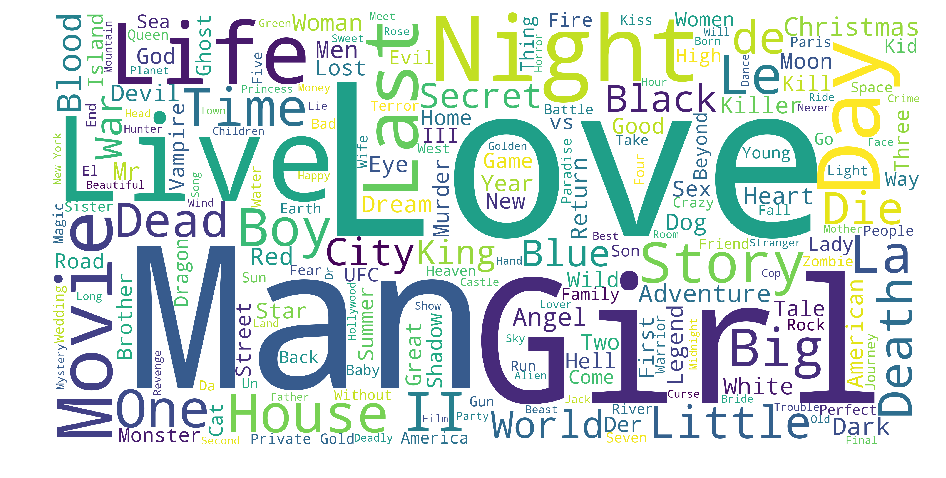

In [8]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Overview

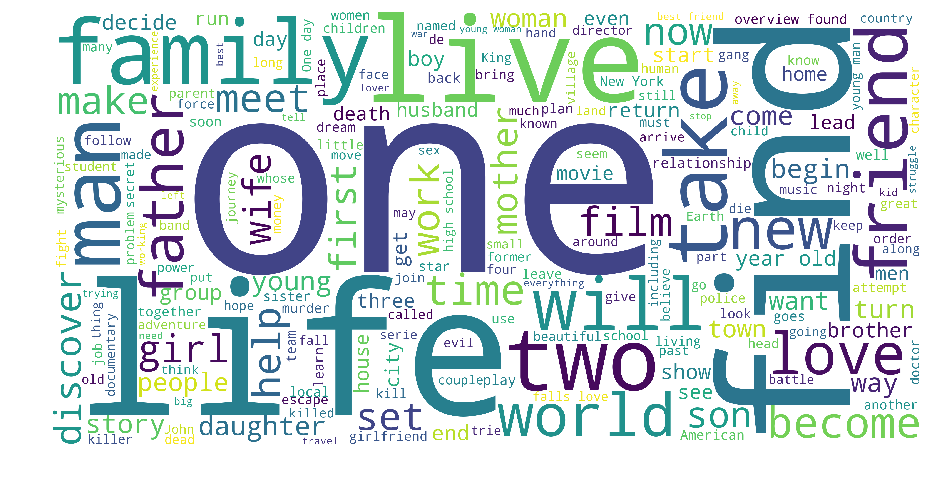

In [9]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

## Production Country

In [6]:
con_df = pd.read_sql_query("SELECT DISTINCT name as country, COUNT(name) as num_movies FROM productioncountries GROUP BY name ORDER BY num_movies DESC ;", con)
con_df.head()

,country,num_movies
0,,28270
1,United States of America,25621
2,France,5058
3,United Kingdom,4366
4,Germany,3397


In [13]:
con_df = con_df[con_df['country'] != 'United States of America']

In [14]:
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_movies'],
        text = con_df['country'],
        colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(255, 0, 0)']],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Production Countries'),
      ) ]

layout = dict(
    title = 'Production Countries for the MovieLens Movies (Apart from US)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

/home/konrad/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Original Language

In [55]:
pd.read_sql_query("SELECT DISTINCT original_language as language, COUNT(original_language) as frequency FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') GROUP BY original_language ORDER BY frequency DESC ;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
language,en,de,fr,it,ja,es,ru,cn,da,hi
frequency,56987,40798,2943,1657,1525,940,710,590,546,530


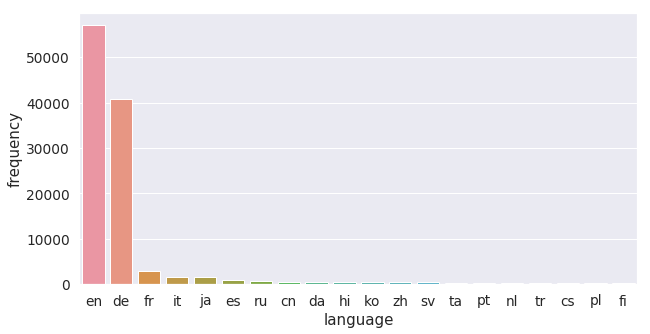

In [66]:
lang_df = pd.read_sql_query("SELECT DISTINCT original_language as language, COUNT(original_language) as frequency FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') GROUP BY original_language ORDER BY frequency DESC ;", con)
plt.figure(figsize=(10,5))
sns.barplot(x = 'language', y = 'frequency', data = lang_df.iloc[0:20])
plt.show()

## Popularity

In [116]:
df = pd.read_sql_query("SELECT DISTINCT movies.*, strftime('%Y', datetime(release_date)) as year FROM movies as movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23');", con)

In [117]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [239]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['revenue'] = df['revenue'].apply(clean_numeric).astype('float')
df['runtime'] = df['runtime'].apply(clean_numeric).astype('float')

In [172]:
df['popularity'].describe()

count    47744.000000
mean         2.111583
std          2.637525
min          0.600000
25%          0.627000
50%          1.124000
75%          2.211250
max         49.011000
Name: popularity, dtype: float64

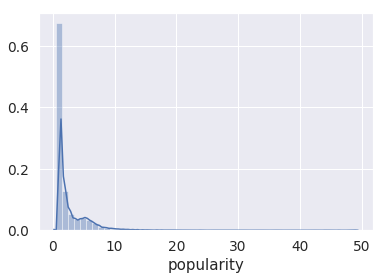

In [173]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

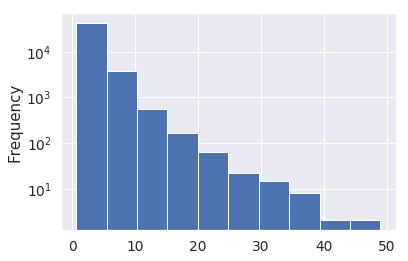

In [174]:
df['popularity'].plot(logy=True, kind='hist')

In [175]:
pd.read_sql_query("SELECT DISTINCT title, popularity, strftime('%Y', datetime(release_date)) as year FROM movies as movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') ORDER BY popularity DESC;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
title,,The Avengers,Harry Potter and the Philosopher's Stone,Pirates of the Caribbean: The Curse of the Bla...,The Lord of the Rings: The Fellowship of the Ring,Eternal Sunshine of the Spotless Mind,Harry Potter and the Chamber of Secrets,The Dark Knight,Die Hard,Titanic
popularity,,49.011,46.233,44.059,42.996,38.463,38.096,36.251,36.091,35.888
year,None,2012,2001,2003,2001,2004,2002,2008,1988,1997


In [176]:
pd.read_sql_query("SELECT DISTINCT title, popularity, strftime('%Y', datetime(release_date)) as year FROM movies as movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23') ORDER BY popularity DESC;", con).tail(10).transpose()

,47733,47734,47735,47736,47737,47738,47739,47740,47741,47742
title,The Story of Molly X,Sesame Street: All-Star Alphabet,The True Meaning of Pictures: Shelby Lee Adams...,Roy Chubby Brown: Dirty Weekend in Blackpool Live,Charisma,Roy Chubby Brown: Too Fat To Be Gay,The Blue Light,Lucky Dog,BlackJack: In the Money,BlackJack- Sweet Science
popularity,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
year,1949,2005,2002,2008,1999,2009,1932,2008,2005,2004


## Vote Count

In [177]:
df['vote_count'].describe()

count    47744.000000
mean       116.769144
std        611.425886
min          0.000000
25%          2.000000
50%          8.000000
75%         29.000000
max      20214.000000
Name: vote_count, dtype: float64

In [178]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10).transpose()

,15974,14148,119,11901,430,45259,1153,552,46253,87
title,Inception,The Avengers,The Dark Knight,Avatar,Fight Club,Django Unchained,Iron Man,Pulp Fiction,The Hunger Games,The Lord of the Rings: The Fellowship of the Ring
vote_count,20214,17421,17273,17165,14746,14282,13741,13582,13480,13126
year,2010,2012,2008,2009,1999,2012,2008,1994,2012,2001


In [179]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).tail(10).transpose()

,25275,38020,38021,38024,25258,33558,16725,34154,42491,44342
title,Das Konto,Yes I Am!,The Smashing Pumpkins: Vieuphoria,Made,Classic Albums: Tom Petty & The Heartbreakers ...,The Muppet Musicians of Bremen,,,,
vote_count,0,0,0,0,0,0,NaN,NaN,NaN,NaN
year,2004,2007,1994,2009,2010,1972,None,None,None,None


## Vote Average

In [180]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    43117.000000
mean         5.945495
std          1.376781
min          0.500000
25%          5.200000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

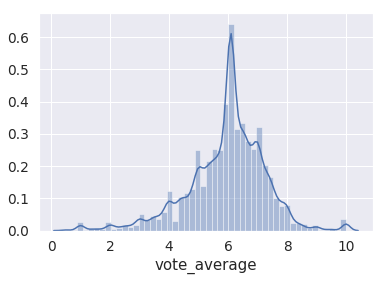

In [181]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

> Without filtering

In [182]:
df[['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10).transpose()

,32157,38334,37100,41795,24900,32559,38909,34429,24923,20105
title,Reno 911: A XXX Parody,"Here I Am, Loving You",West of Pluto,The Girl with the Golden Eyes,Perfect Combination,Korn: Live,Dancing Angels,Henry Rollins: Uncut From Israel,Sztracsatella,Derren Brown: An Evening of Wonders
vote_average,10,10,10,10,10,10,10,10,10,10
vote_count,3,1,1,1,1,2,1,1,1,1
year,2010,2009,2008,1961,2010,2002,1988,2007,1996,2009


> With filtering

In [183]:
df[df['vote_count'] > 139][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10).transpose()

,11602,194,232,96,334,196,6215,7105,741,610
title,Dilwale Dulhania Le Jayenge,The Godfather,The Shawshank Redemption,Spirited Away,Schindler's List,The Godfather: Part II,Cinema Paradiso,Grave of the Fireflies,City Lights,GoodFellas
vote_average,9.1,8.6,8.6,8.5,8.5,8.5,8.4,8.4,8.4,8.4
vote_count,1954,9032,11809,6546,7040,5269,1500,1765,762,4994
year,1995,1972,1994,2001,1993,1974,1988,1988,1931,1990


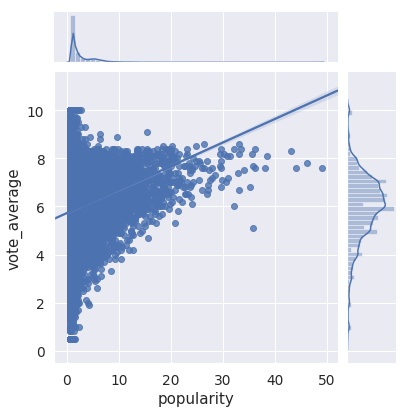

In [184]:
sns.jointplot(x='popularity', y='vote_average', data=df, kind='reg')

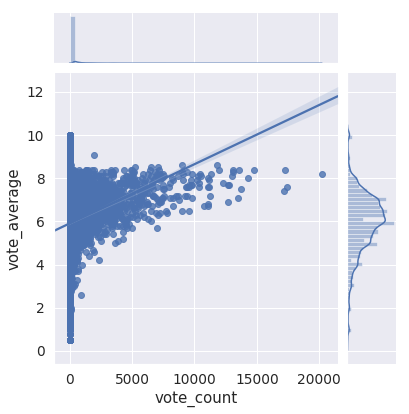

In [185]:
sns.jointplot(x='vote_count', y='vote_average', data=df, kind='reg')

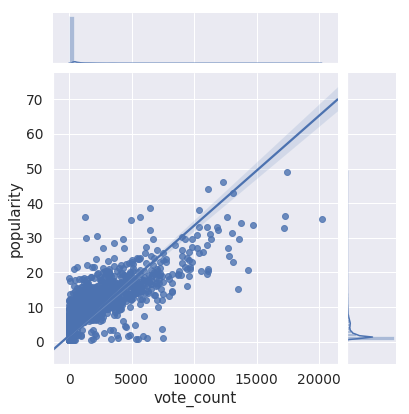

In [186]:
sns.jointplot(x='vote_count', y='popularity', data=df, kind='reg')

## Release date

In [187]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [188]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [189]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [190]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

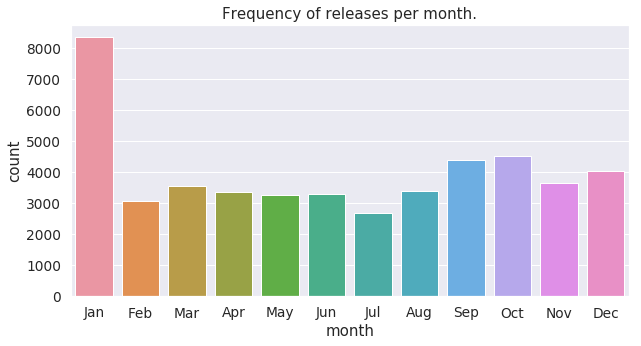

In [191]:
plt.figure(figsize=(10,5))
plt.title("Frequency of releases per month.")
sns.countplot(x='month', data=df, order=month_order)

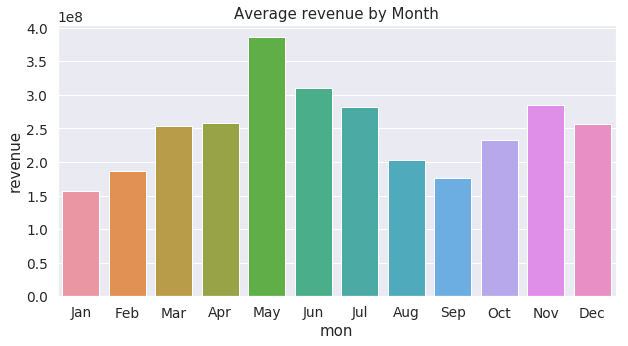

In [211]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(10,5))
plt.title("Average revenue by Month")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

In [196]:
df['return'] = df['revenue'] / df['budget']

(0, 12)

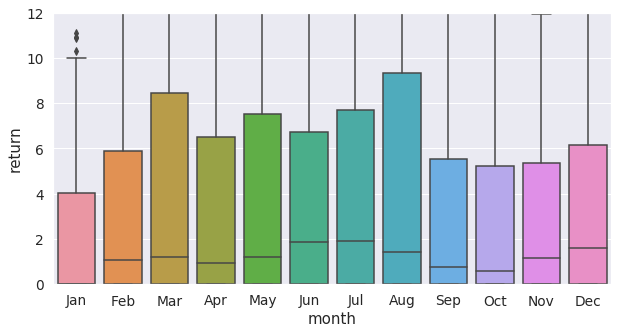

In [217]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
sns.boxplot(x='month', y='return', data=df[df['return'].notnull()], ax =ax, order=month_order)
ax.set_ylim([0, 12])

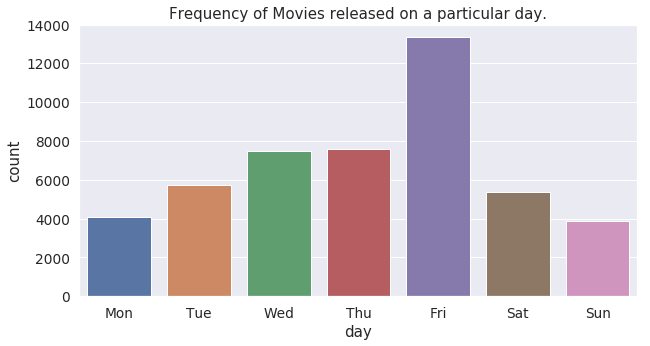

In [216]:
plt.figure(figsize=(10,5))
plt.title("Frequency of Movies released on a particular day.")
sns.countplot(x='day', data=df, order=day_order)

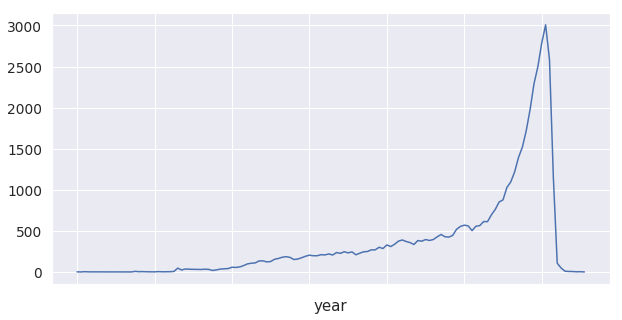

In [219]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(10,5))
year_count.plot()

In [220]:
df[df['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
9894,Roundhay Garden Scene,1888
9895,Traffic Crossing Leeds Bridge,1888
19817,"Leisurely Pedestrians, Open Topped Buses and H...",1889
20283,"Monkeyshines, No. 2",1890
20284,London's Trafalgar Square,1890
19898,"Monkeyshines, No. 1",1890
20285,"Monkeyshines, No. 3",1890
20286,Men Boxing,1891
20241,Dickson Greeting,1891
9953,Un bon bock,1892


In [225]:
type(df['year'])

pandas.core.series.Series

In [221]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [233]:
df_21 = df.copy()
#df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >='1988']
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

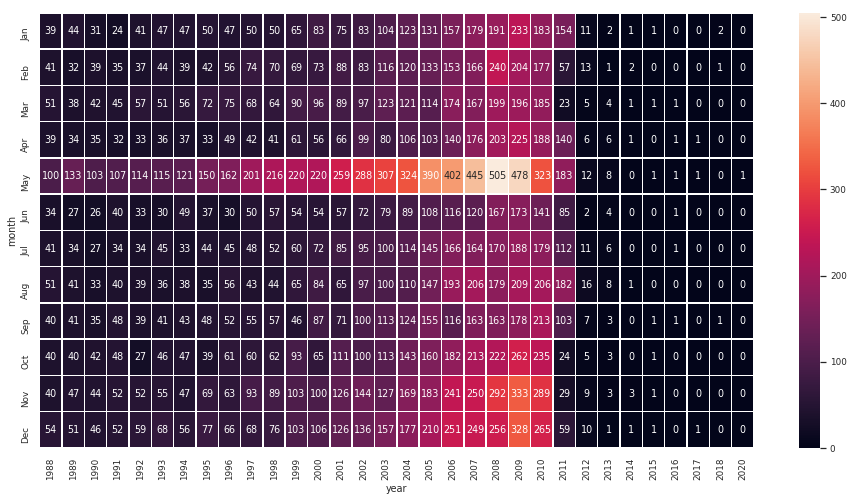

In [236]:
sns.set(font_scale=0.8)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

In [285]:
sns.set(font_scale=1.25)

## Status

In [286]:
df['status'].value_counts()

Released           47721
Rumored                8
Planned                8
                       4
In Production          3
Canceled               2
Post Production        2
Name: status, dtype: int64

## Runtime

In [287]:
df['runtime'].describe()

count    44561.000000
mean        94.959606
std         35.159297
min          1.000000
25%         85.000000
50%         94.000000
75%        106.000000
max       1635.000000
Name: runtime, dtype: float64

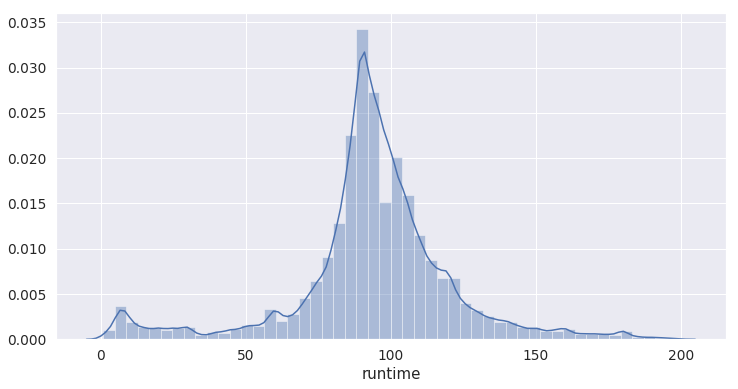

In [288]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 200) & (df['runtime'] > 0)]['runtime'])

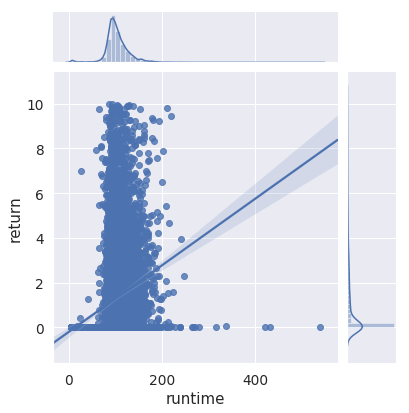

In [289]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return'] < 10)]
sns.jointplot('runtime', 'return', kind='reg', data=df_mat)
plt.show()

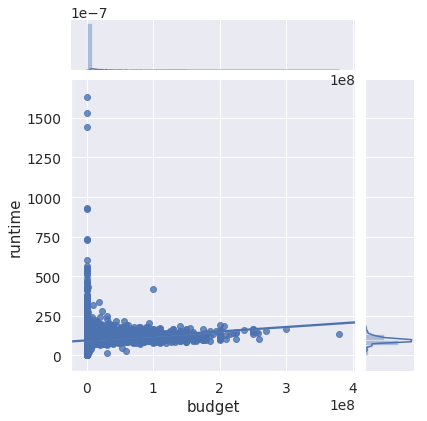

In [290]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', kind='reg', data=df_mat)
plt.show()

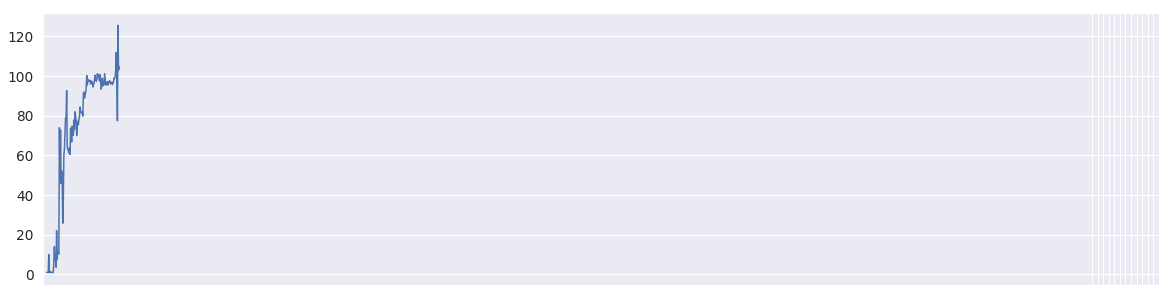

In [291]:
plt.figure(figsize=(20,5))
year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
plt.plot(year_runtime.index, year_runtime)
plt.xticks(np.arange(1874, 2000, 10.0))
plt.show()

In [260]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10).transpose()

,27143,44445,21743,29258,44437,47518,42264,26786,26365,12698
runtime,1635,1532,1440,931,925,735,730,600,566,553
title,UFC: The Ultimate 100 Greatest Fights,Heimat 2: A Chronicle of a Generation,24 Hours Berlin,Berlin Alexanderplatz,Heimat: A Chronicle of Germany,A Dream in Red Mansions,Edison: The Invention of the Movies,Zwarte sneeuw,Shoah,Woody Woodpecker and Friends
year,2009,1992,2009,1980,1984,1988,2005,None,1985,1982


In [261]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10).transpose()

,34109,9946,45595,40512,9896,45609,9895,9894,45211,44449
runtime,1,1,1,1,1,1,1,1,1,1
title,The Big Sellout,Carmencita,No Neck Joe,Ice Egg,The Infernal Caldron,X-Ray Men from Mars,Traffic Crossing Leeds Bridge,Roundhay Garden Scene,Misfit,My Grandpa the Bankrobber
year,2007,1894,1996,2002,1903,1978,1888,1888,1997,2011


## Budget

In [263]:
df['budget'].describe()

count    4.774800e+04
mean     3.168028e+06
std      1.463268e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.800000e+08
Name: budget, dtype: float64

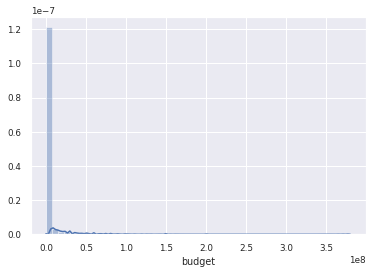

In [264]:
sns.distplot(df[df['budget'].notnull()]['budget'])

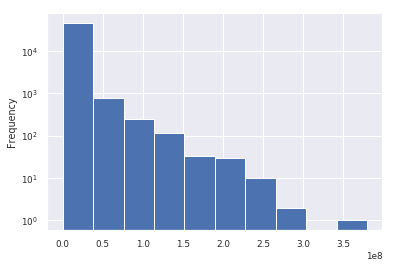

In [284]:
df['budget'].plot(logy=True, kind='hist')

In [270]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(10).transpose()

,1240,237,970,23708,438,37742,32291,37719,31884,608
title,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: At World's End,Superman Returns,Tangled,Spider-Man 3,The Lone Ranger,John Carter,The Hobbit: The Desolation of Smaug,The Dark Knight Rises,Harry Potter and the Half-Blood Prince
budget,380000000,300000000,270000000,260000000,258000000,255000000,250000000,250000000,250000000,250000000
revenue,1.04571e+09,9.61e+08,3.91081e+08,5.91795e+08,8.90872e+08,8.92899e+07,2.84139e+08,9.584e+08,1.08494e+09,9.33959e+08
return,2.75188,3.20333,1.44845,2.27613,3.45299,0.350157,1.13656,3.8336,4.33976,3.73584
year,2011,2007,2006,2010,2007,2013,2012,2013,2012,2009


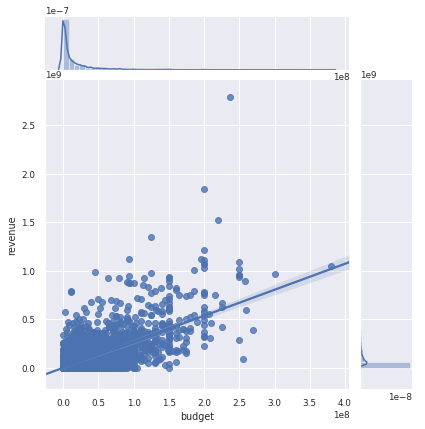

In [272]:
sns.jointplot(x='budget',y='revenue', kind='reg', data=df[df['return'].notnull()])

## Revenue

In [275]:
df['revenue'].describe()

count    4.774400e+04
mean     8.107579e+06
std      5.182118e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

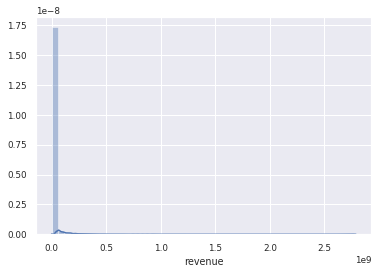

In [277]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])

In [282]:
gross_top = df[['poster_path', 'title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10).transpose()
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,11901,473,14148,7084,45262,23411,89,22919,31884,5284
poster_path,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,/kHXEpyfl6zqn8a6YuozZUujufXf.jpg,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,/fTplI1NCSuEDP4ITLcTps739fcC.jpg,/1Ilv6ryHUv6rt9zIsbSEJUmmbEi.jpg,/sZY3ls18QTY0pFBJn2vl2MmauTQ.jpg,/rCzpDGLbOoPwLjy3OAm5NUPOTrC.jpg,/lQCkPLDxFONmgzrWLvq085v1g2d.jpg,/dEYnvnUfXrqvqeRSqvIEtmzhoA8.jpg,/mMltbSxwEdNE4Cv8QYLpzkHWTDo.jpg
title,Avatar,Titanic,The Avengers,Harry Potter and the Deathly Hallows: Part 2,Iron Man 3,Transformers: Dark of the Moon,The Lord of the Rings: The Return of the King,Skyfall,The Dark Knight Rises,Toy Story 3
budget,237000000,200000000,220000000,125000000,200000000,195000000,94000000,200000000,250000000,200000000
revenue,2.78797e+09,1.84503e+09,1.51956e+09,1.342e+09,1.21544e+09,1.12375e+09,1.11889e+09,1.10856e+09,1.08494e+09,1.06697e+09
year,2009,1997,2012,2011,2013,2011,2003,2012,2012,2010


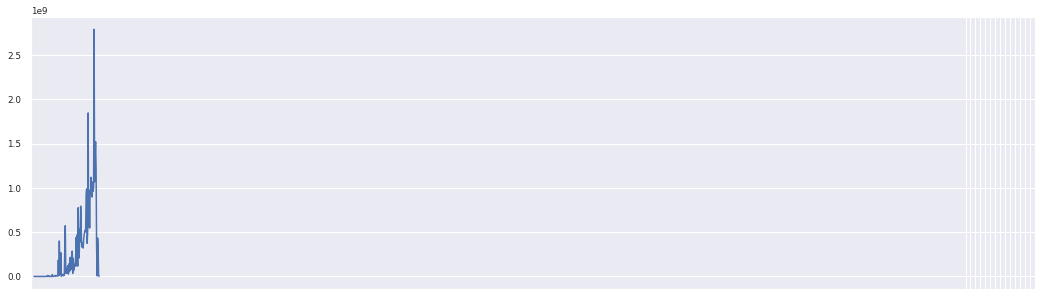

In [283]:
plt.figure(figsize=(18,5))
year_revenue = df[(df['revenue'].notnull()) & (df['year'] != 'NaT')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(np.arange(1874, 2024, 10.0))
plt.show()

## Returns

In [293]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
477,E.T. the Extra-Terrestrial,10500000,792965326.0,75.520507,1982
6,Star Wars,11000000,775398007.0,70.490728,1977
455,Jaws,7000000,470700000.0,67.242857,1975
4710,The Exorcist,8000000,441306145.0,55.163268,1973
582,Four Weddings and a Funeral,6000000,254700832.0,42.450139,1994
194,The Godfather,6000000,245066411.0,40.844402,1972
4658,Look Who's Talking,7500000,296000000.0,39.466667,1989
56,Dirty Dancing,6000000,213893795.0,35.648966,1987
8964,The Sound of Music,8200000,286214286.0,34.904181,1965
82,Pretty Woman,14000000,463000000.0,33.071429,1990


In [294]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head(10)

,title,budget,revenue,return,year
2984,Chaos,20000000,10289.0,0.000514,2005
33060,5 Days of War,20000000,17479.0,0.000874,2011
2029,"The Tulse Luper Suitcases, Part 3: From Sark to the Finish",10000000,12000.0,0.001200,2004
7789,The Good Night,15000000,20380.0,0.001359,2007
9391,Cherry 2000,10000000,14000.0,0.001400,1987
19371,All The Queen's Men,15000000,23000.0,0.001533,2001
4034,The Red Baron,18000000,40239.0,0.002236,2008
10591,Freaked,13000000,29296.0,0.002254,1993
2028,"The Tulse Luper Suitcases, Part 2: Vaux to the Sea",10000000,24250.0,0.002425,2004
2027,"The Tulse Luper Suitcases, Part 1: The Moab Story",10000000,25800.0,0.002580,2003


## Correlation matrix

In [295]:
df['year'] = df['year'].replace('NaT', np.nan)

In [296]:
df['year'] = df['year'].apply(clean_numeric)

In [308]:
cm = df[['budget','revenue','return','popularity','runtime','vote_average','vote_count']]

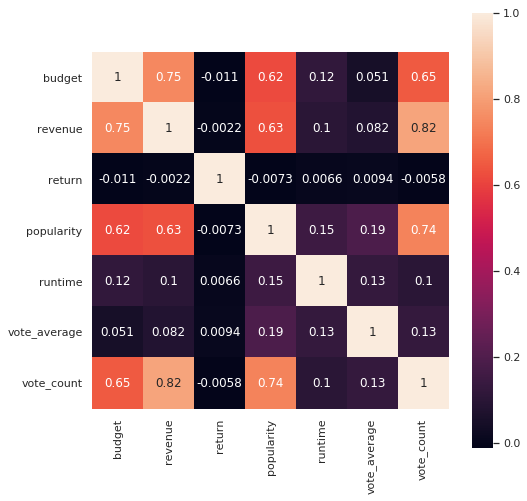

In [316]:
sns.set(font_scale=1)
corr = cm.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = False
with sns.axes_style("white"):
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True)

## Genres

In [338]:
pd.read_sql_query("SELECT name, COUNT(id) AS id_counted FROM genres WHERE imdb_id <> '' GROUP BY name ORDER BY id_counted DESC;", con).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
name,Drama,Comedy,Action,Horror,Documentary,Crime,Animation,Adventure,Thriller,Music,Romance,Family,Fantasy,Science Fiction,Mystery,Western,TV Movie,War,History
id_counted,9593,8773,4351,2651,2476,1642,1474,1271,1110,969,892,640,597,502,438,341,321,232,207


In [332]:
df = pd.read_sql_query("SELECT name, COUNT(id) AS id_counted FROM genres WHERE imdb_id <> '' GROUP BY name ORDER BY id_counted DESC;", con)

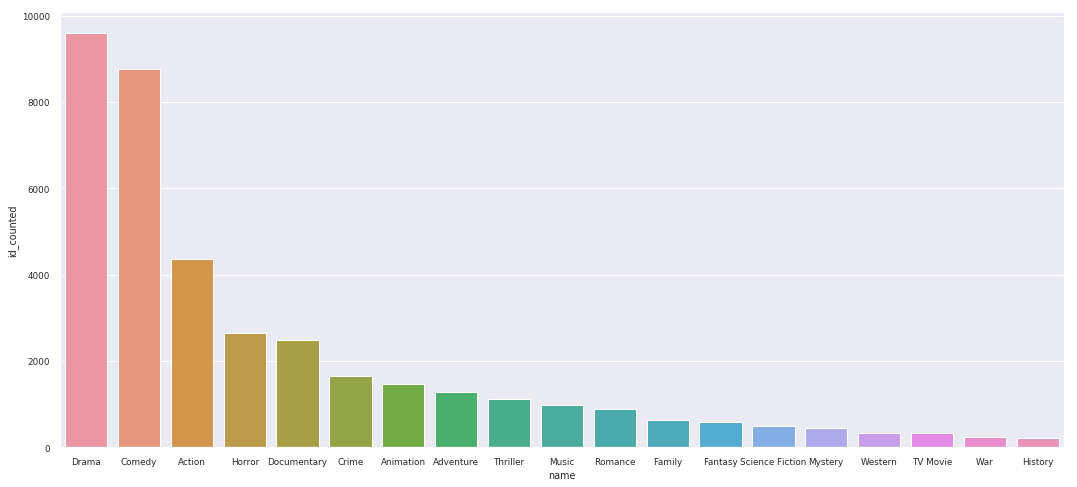

In [365]:
sns.set(font_scale=0.8)
plt.figure(figsize=(18,8))
sns.barplot(x='name', y='id_counted', data=df)
plt.show()

In [73]:
pd.read_sql_query("SELECT DISTINCT g.*, m.revenue, strftime('%Y', datetime(m.release_date)) as year FROM (SELECT DISTINCT * FROM genres WHERE imdb_id <> '') AS g INNER JOIN (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) AS m ON g.imdb_id = m.imdb_id ORDER BY release_date DESC;", con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
id,53,35,35,35,18,27,27,28,28,28
name,Thriller,Comedy,Comedy,Comedy,Drama,Horror,Horror,Action,Action,Action
imdb_id,tt1502397,tt7023452,tt7510220,tt0859635,tt0835802,tt1139592,tt0498381,tt1293847,tt1289401,tt1628841
revenue,0,0,0,1.88507e+07,0,0,8.30809e+07,3.46148e+08,2.29148e+08,3.89682e+08
year,2020,2018,2018,2018,2018,2017,2017,2017,2016,2016


In [85]:
genres = pd.read_sql_query("SELECT DISTINCT name AS genre FROM genres;", con)
gen_df = pd.read_sql_query("SELECT DISTINCT g.id, g.name AS genre, g.imdb_id, m.revenue, strftime('%Y', datetime(m.release_date)) as year FROM (SELECT DISTINCT * FROM genres WHERE imdb_id <> '') AS g INNER JOIN (SELECT DISTINCT * FROM movies WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) AS m ON g.imdb_id = m.imdb_id ORDER BY release_date DESC;", con)

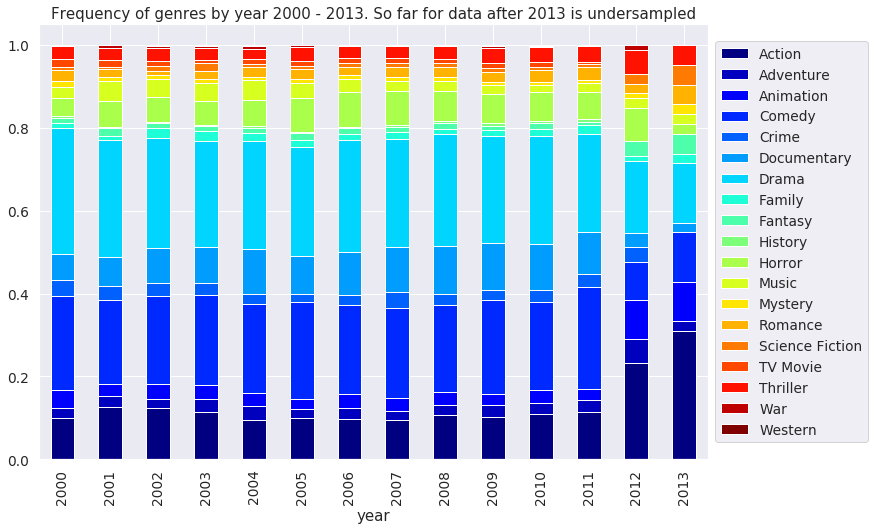

In [86]:
pop_gen_movies = gen_df[(gen_df['year'] >= '2000') & (gen_df['year'] <= '2013')]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
#print(ctab)
ctab.plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Frequency of genres by year 2000 - 2013. So far for data after 2013 is undersampled")
plt.show()

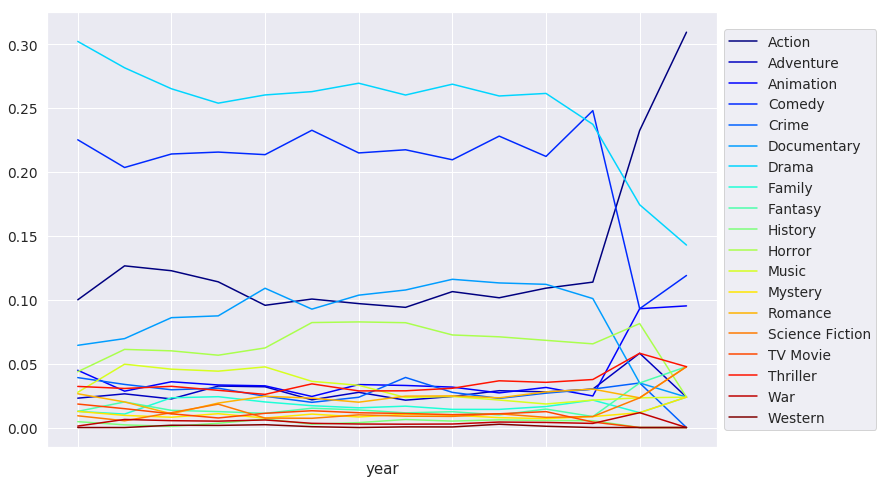

In [87]:
ctab.plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

ValueError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1296x576 with 0 Axes>

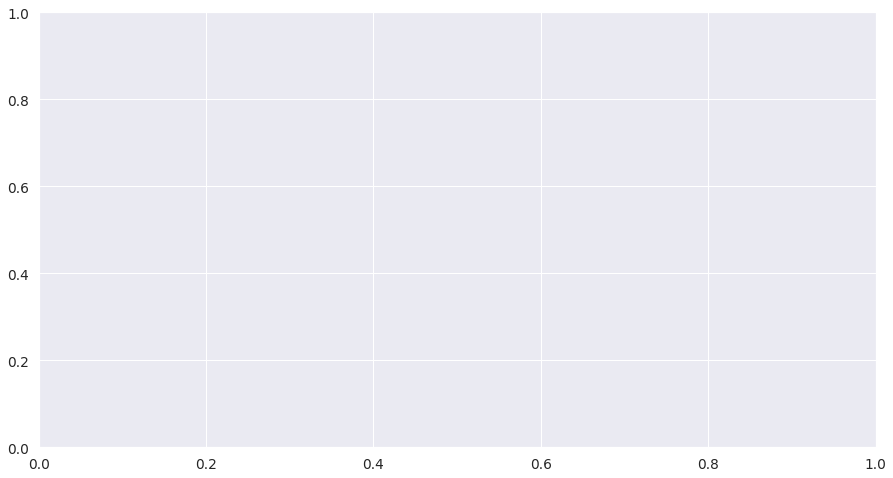

In [90]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=gen_df, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

ValueError: Could not interpret input 'return'

<Figure size 1296x576 with 0 Axes>

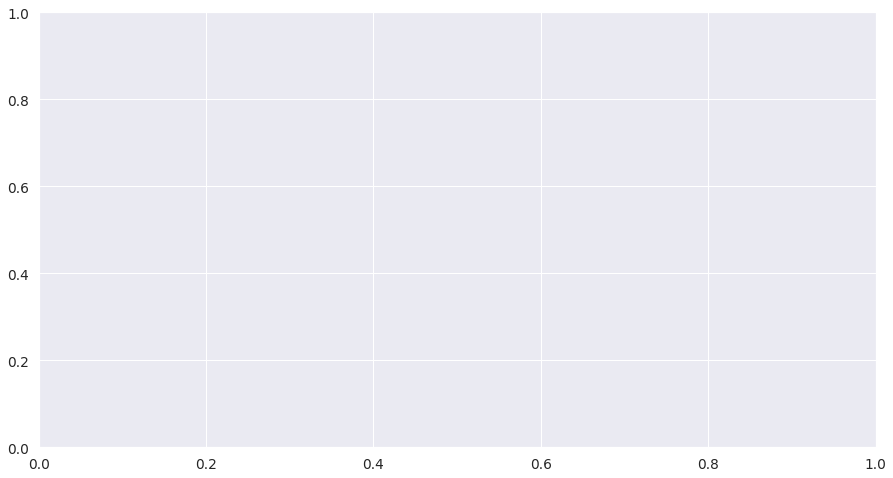

In [92]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=gen_df, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

## Cast

## Crew

# Custom Rating

> The value of X percentile for given distribution of vote_count:

In [5]:
percentile = 90

> Computing the value of cutoff

In [6]:
pd.read_sql_query("SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1;", con)

,vote_count_90_percentile
0,139


> Head 10 transposed

In [57]:
pd.read_sql_query("SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC;" , con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
idx,0,0,0,0,0,0,0,0,0,0
budget,8000000,0,58000000,0,21000000,0,2800000,0,0,4000000
id,400,1721,2148,2517,10606,11223,11305,13691,15251,16873
imdb_id,tt0114660,tt0069095,tt0087089,tt0408664,tt0087910,tt0077355,tt0097940,tt0323642,tt0085474,tt0858486
original_language,en,it,en,ja,en,en,en,en,en,en
original_title,Things to Do in Denver When You're Dead,...più forte ragazzi!,The Cotton Club,誰も知らない,The Philadelphia Experiment,Coma,Mystery Train,Piglet's Big Movie,Eddie Murphy: Delirious,Battle for Terra
overview,A mafia film in Tarantino style with a star-st...,"The ""Trinity"" crew makes another modern era fi...",The story of the people that frequented Harlem...,"In a small Tokyo apartment, twelve-year-old Ak...","Based on an ""actual event"" that took place in ...",A young woman doctor discovers something sinis...,"A seedy hotel in Memphis, Tennessee, provides ...",When the gang from the Hundred Acre Wood begin...,Taped live and in concert at Constitution Hall...,"A peaceful alien planet faces annihilation, as..."
popularity,5.734,6.233,6.011,5.642,5.025,5.648,3.967,4.932,5.233,5.119
poster_path,/ysKIolKO0376Nl5DV1fDAAPudEq.jpg,/hfra5i11GjZf0pdwseA2OUDZkR5.jpg,/qigf5fWSH1tw7z424UVKg71UIOS.jpg,/kDQSwhkiHttHt0OlPNdmnrBsTki.jpg,/4J0n9oFLfdkcCA86bXCnViJKxzd.jpg,/wXhYCwf7yhnvlJxhl8nIcSWb4Aw.jpg,/vcr6pBGeHWfjiWH6HarEEXdJIlG.jpg,/gM4rWSXfPMeXorIKXNr5kuxLPkz.jpg,/nopK3L1aJYCuEiSQTqwpZD7uff7.jpg,/hE71YvRdNaILXxPf0iASqqFTCSv.jpg
release_date,1995-12-01,1972-12-22,1984-12-14,2004-08-07,1984-08-03,1978-01-06,1989-09-06,2003-03-16,1983-08-17,2007-09-06


> Tail 10 transposed

In [58]:
pd.read_sql_query("SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC;" , con).tail(10).transpose()

,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773
idx,0,0,0,0,0,0,0,0,0,0
budget,100000000,63000000,237000000,185000000,220000000,160000000,0,0,0,0
id,68718,550,19995,155,24428,27205,28102,52141,64659,67334
imdb_id,tt1853728,tt0137523,tt0499549,tt0468569,tt0848228,tt1375666,tt2061710,tt1585561,tt0416746,tt0436852
original_language,en,en,en,en,en,en,en,de,en,de
original_title,Django Unchained,Fight Club,Avatar,The Dark Knight,The Avengers,Inception,Ilse DeLange: Live In Ahoy,Die Fantastischen Vier: Heimspiel,Food Will Win the War,True Love
overview,"With the help of a German bounty hunter, a fre...",A ticking-time-bomb insomniac and a slippery s...,"In the 22nd century, a paraplegic Marine is di...",Batman raises the stakes in his war on crime. ...,When an unexpected enemy emerges and threatens...,"Cobb, a skilled thief who commits corporate es...",Tracklisting:,Tracklisting:,World War II propaganda film on the importance...,Seven short stories about growing up gay in Am...
popularity,20.567,33.581,32.934,36.251,49.011,35.524,,,,
poster_path,/5WJnxuw41sddupf8cwOxYftuvJG.jpg,/adw6Lq9FiC9zjYEpOqfq03ituwp.jpg,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,/qmDpIHrmpJINaRKAfWQfftjCdyi.jpg,,,,
release_date,2012-12-25,1999-10-15,2009-12-10,2008-07-16,2012-04-25,2010-07-15,,,,


> Computing Global Average

In [59]:
pd.read_sql_query("SELECT AVG(vote_average) as vote_average_global FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'));" , con)

,vote_average_global
0,5.368851


> Setting minimum size of vote_count

In [60]:
MinimumVotes = 250.0

> Computing Score <br>
> Head 10 transposed

In [61]:
pd.read_sql_query("SELECT id, imdb_id, title, vote_count, vote_average, (vote_count / (vote_count + MinimumVotes) * vote_average) + (MinimumVotes / (vote_count + MinimumVotes * VoteAvarageGlobal)) AS Score FROM (SELECT id, imdb_id, title, vote_count, " + str(MinimumVotes) + " as MinimumVotes, vote_average, (SELECT AVG(vote_average) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) AS VoteAvarageGlobal FROM (SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id <> '') WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC)) as ParametersForScore ORDER BY Score DESC;" , con).head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
id,278,238,155,550,680,13,122,424,129,120
imdb_id,tt0111161,tt0068646,tt0468569,tt0137523,tt0110912,tt0109830,tt0167260,tt0108052,tt0245429,tt0120737
title,The Shawshank Redemption,The Godfather,The Dark Knight,Fight Club,Pulp Fiction,Forrest Gump,The Lord of the Rings: The Return of the King,Schindler's List,Spirited Away,The Lord of the Rings: The Fellowship of the Ring
vote_count,11809,9032,17273,14746,13582,13098,11955,7040,6546,13126
vote_average,8.6,8.6,8.4,8.4,8.4,8.4,8.4,8.5,8.5,8.3
Score,8.44072,8.39247,8.29359,8.2755,8.26493,8.25999,8.24674,8.23833,8.21901,8.16215


> Tail 10 transposed

In [62]:
pd.read_sql_query("SELECT id, imdb_id, title, vote_count, vote_average, (vote_count / (vote_count + MinimumVotes) * vote_average) + (MinimumVotes / (vote_count + MinimumVotes * VoteAvarageGlobal)) AS Score FROM (SELECT id, imdb_id, title, vote_count, " + str(MinimumVotes) + " as MinimumVotes, vote_average, (SELECT AVG(vote_average) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) AS VoteAvarageGlobal FROM (SELECT * FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) WHERE vote_count > (SELECT vote_count AS vote_count_" + str(percentile) + "_percentile FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23')) ORDER BY vote_count ASC LIMIT 1 OFFSET (SELECT COUNT(*) FROM (SELECT DISTINCT * FROM MOVIES WHERE imdb_id NOT IN ('','1942-07-20','2005-05-10','2009-08-20','2009-10-23'))) * " + str(percentile) + " / 100 - 1) ORDER BY vote_count ASC)) as ParametersForScore ORDER BY Score DESC;" , con).tail(10).transpose()

,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773
id,8046,26914,17711,10870,9544,11059,28102,52141,64659,67334
imdb_id,tt0299930,tt0105643,tt0131704,tt0368668,tt0295254,tt0317676,tt2061710,tt1585561,tt0416746,tt0436852
title,Gigli,Troll 2,The Adventures of Rocky & Bullwinkle,Lucky Luke and the Daltons,FearDotCom,House of the Dead,,,,
vote_count,171,156,149,142,147,151,,,,
vote_average,3.6,3.8,3.9,3.9,3.4,2.9,,,,
Score,1.62744,1.62696,1.62404,1.58119,1.42682,1.25944,0.18626,0.18626,0.18626,0.18626


# Text Mining

> Big Data? Aaaaand it is done...

In [16]:
overview_table = pd.read_sql_query("SELECT DISTINCT imdb_id, title, overview FROM Movies WHERE overview <> ''", con)
overview_table.head

<bound method NDFrame.head of          imdb_id                                              title  \
0      tt0094675                                              Ariel   
1      tt0092149                                Shadows in Paradise   
2      tt0113101                                         Four Rooms   
3      tt0107286                                     Judgment Night   
4      tt0825671                   Life in Loops (A Megacities RMX)   
5      tt0076759                                          Star Wars   
6      tt0266543                                       Finding Nemo   
7      tt0109830                                       Forrest Gump   
8      tt0169547                                    American Beauty   
9      tt0033467                                       Citizen Kane   
10     tt0168629                                 Dancer in the Dark   
11     tt0411267                                           The Dark   
12     tt0119116                               

In [17]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
overview_table['overview'] = overview_table['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(overview_table['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(49889, 100802)

In [18]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

start_time = time.time()
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print("--- %s seconds ---" % (time.time() - start_time))

print(cosine_sim)

--- 71.08556294441223 seconds ---
[[1.         0.01459959 0.         ... 0.01030255 0.01809111 0.        ]
 [0.01459959 1.         0.         ... 0.01452822 0.         0.        ]
 [0.         0.         1.         ... 0.01014582 0.         0.        ]
 ...
 [0.01030255 0.01452822 0.01014582 ... 1.         0.00773699 0.        ]
 [0.01809111 0.         0.         ... 0.00773699 1.         0.09669952]
 [0.         0.         0.         ... 0.         0.09669952 1.        ]]


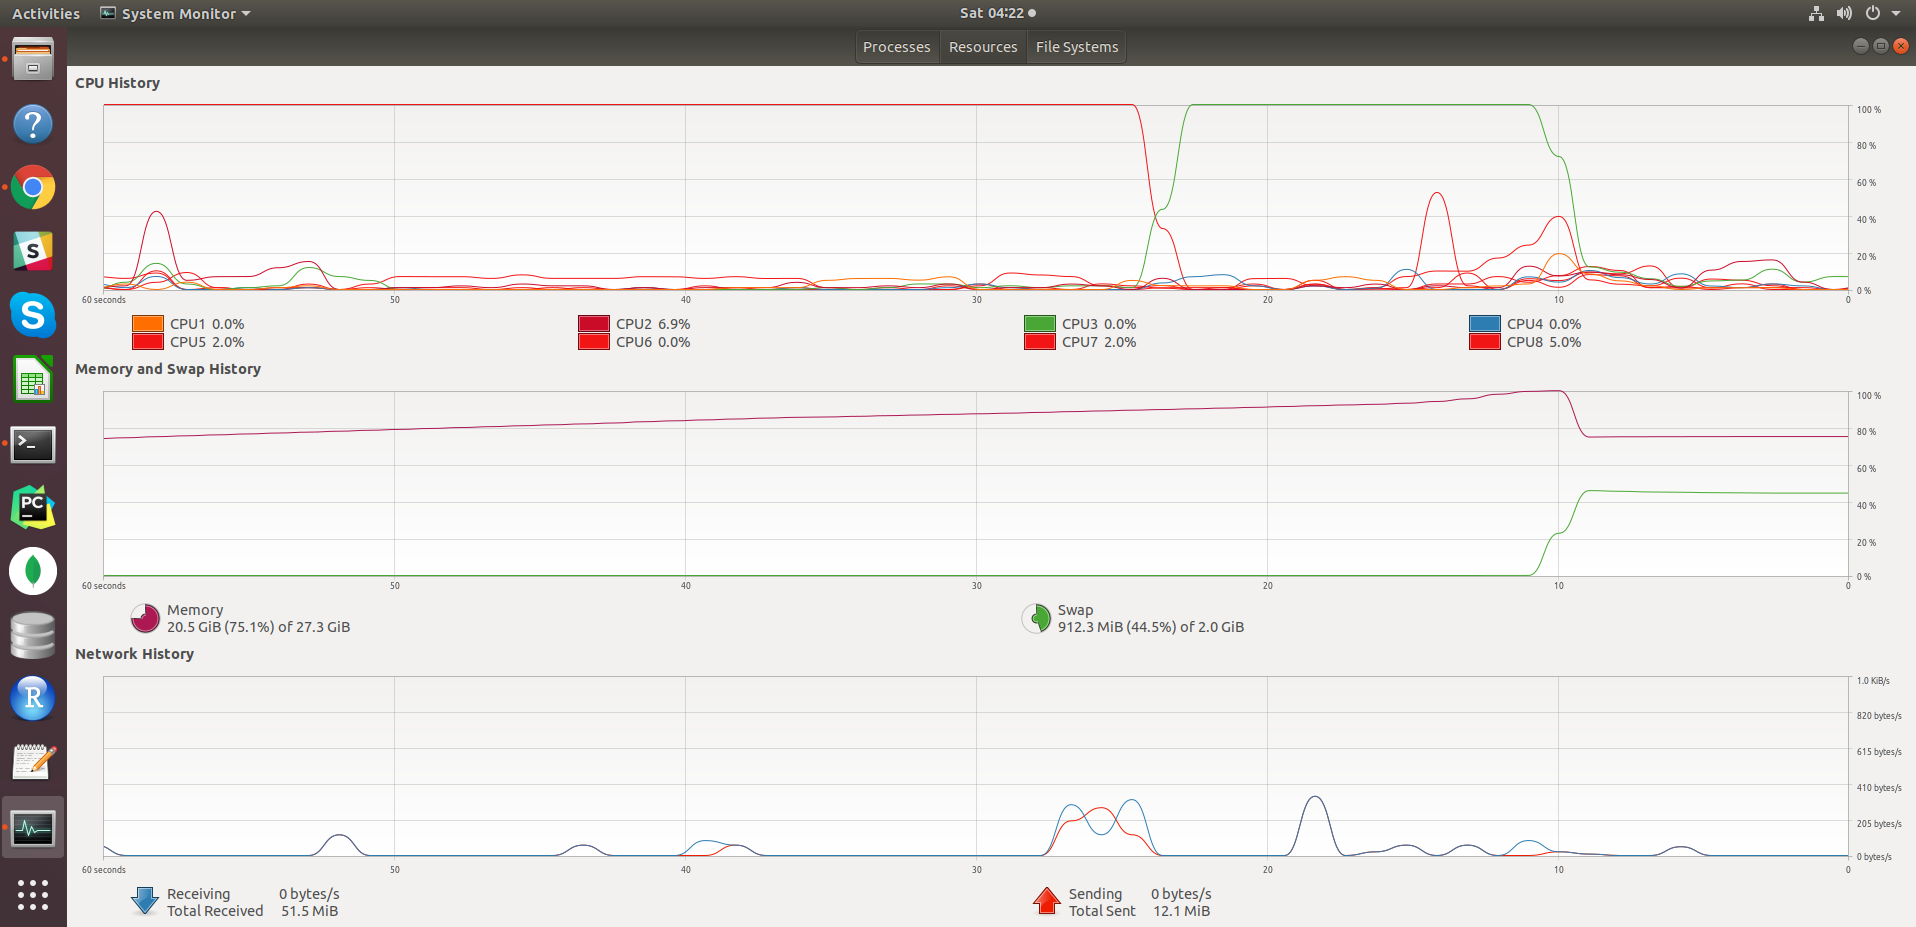

In [19]:
Image(filename = "/home/konrad/Pictures/Screenshot from 2019-01-05 04-22-31.png", width=1000, height=1000)

In [20]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(overview_table.index, index=overview_table['title']).drop_duplicates()
indices.head

<bound method NDFrame.head of title
Ariel                                                             0
Shadows in Paradise                                               1
Four Rooms                                                        2
Judgment Night                                                    3
Life in Loops (A Megacities RMX)                                  4
Star Wars                                                         5
Finding Nemo                                                      6
Forrest Gump                                                      7
American Beauty                                                   8
Citizen Kane                                                      9
Dancer in the Dark                                               10
The Dark                                                         11
The Fifth Element                                                12
Metropolis                                                       13
My Life With

In [21]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[0:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return overview_table['title'].iloc[movie_indices]

In [22]:
get_recommendations('Short Circuit')

1734          Short Circuit
11946         Robot Stories
20018      Making Mr. Right
29850    Eve of Destruction
10178            Omega Doom
3099            Star Virgin
2131           Robot Wrecks
19321            R.O.T.O.R.
1582       Bicentennial Man
16437     Exterminator City
44018              Robotrix
Name: title, dtype: object